In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
#导入必要的库

In [192]:
#设置LSTM、GRU的时间窗
window=4
#读取数据
data = np.load('./data.npy')
data=data.transpose() 
data=pd.DataFrame(data)
data.tail()

,0,1,2,3,4,5,6,7,8,9,...,330,331,332,333,334,335,336,337,338,339
115,0.461812,0.461812,0.461812,0.728745,0.728261,0.730679,0.762595,0.772750,0.842868,0.890258,...,0.488312,0.432701,0.472354,0.531447,0.493051,0.514038,0.461812,0.461812,0.461812,1.0
116,0.468591,0.468591,0.468591,0.631364,0.666788,0.720876,0.774342,0.858724,0.919797,0.940119,...,0.425095,0.455273,0.512760,0.527557,0.517468,0.502222,0.468591,0.468591,0.468591,0.0
117,0.462199,0.462199,0.462199,0.611755,0.651390,0.720354,0.777188,0.827144,0.894410,0.932055,...,0.419657,0.418336,0.459002,0.518216,0.549131,0.539883,0.462199,0.462199,0.462199,0.0
118,0.519990,0.519990,0.519990,0.664633,0.684126,0.702438,0.725785,0.751159,0.767976,0.817314,...,0.508386,0.540401,0.580740,0.610794,0.602436,0.611276,0.519990,0.519990,0.519990,1.0
119,0.504391,0.504391,0.504391,0.693947,0.707192,0.758719,0.820184,0.874096,0.937997,0.976359,...,0.480593,0.506585,0.543089,0.567094,0.569991,0.540606,0.504391,0.504391,0.504391,0.0


In [193]:
#进行数据归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data0=min_max_scaler.fit_transform(data)
data = pd.DataFrame(data0, columns=data.columns)
data.tail()

,0,1,2,3,4,5,6,7,8,9,...,330,331,332,333,334,335,336,337,338,339
115,0.548900,0.548900,0.548900,0.760862,0.754525,0.724677,0.754925,0.680436,0.756671,0.789520,...,0.743276,0.525512,0.417270,0.583607,0.426848,0.610215,0.548900,0.548900,0.548900,1.0
116,0.576804,0.576804,0.576804,0.490284,0.582925,0.697733,0.785503,0.874722,0.914141,0.885152,...,0.581457,0.591727,0.601422,0.569849,0.519666,0.566440,0.576804,0.576804,0.576804,0.0
117,0.550491,0.550491,0.550491,0.435798,0.539939,0.696300,0.792912,0.803358,0.862174,0.869685,...,0.567537,0.483373,0.356414,0.536808,0.640033,0.705963,0.550491,0.550491,0.550491,0.0
118,0.788375,0.788375,0.788375,0.582724,0.631323,0.647057,0.659112,0.631644,0.603373,0.649616,...,0.794661,0.841446,0.911251,0.864275,0.842667,0.970448,0.788375,0.788375,0.788375,1.0
119,0.724167,0.724167,0.724167,0.664176,0.695710,0.801746,0.904828,0.909461,0.951394,0.954658,...,0.723518,0.742249,0.739652,0.709699,0.719328,0.708639,0.724167,0.724167,0.724167,0.0


18


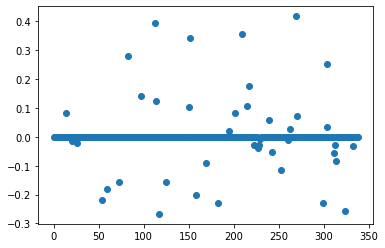

In [194]:
#特征选择 
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=.0005)
x=data.iloc[:,:-1]
y=data.iloc[:,-1]
lasso.fit(x, y)
plt.plot(lasso.coef_,'o', label = 'lasso')
index=lasso.coef_>0
coef=[int(i) for i in index]
x=x*coef
#降维
x=pd.DataFrame(x)
x=x.loc[:, (x != 0).any(axis=0)]#删除全0列
data=pd.concat([x,y],axis=1)
print(len(x.iloc[1,:]))#还剩多少列特征

In [195]:
stock=data
seq_len=window
input_size=len(data.iloc[1,:])
amount_of_features = len(stock.columns)#有几列
data = stock.as_matrix() #pd.DataFrame(stock) 表格转化为矩阵
sequence_length = seq_len + 1#序列长度5+1
result = []
for index in range(len(data) - sequence_length):#循环170-5次
    result.append(data[index: index + sequence_length])#第i行到i+5
result = np.array(result)#得到161个样本，样本形式为6天*3特征
row = round(0.9 * result.shape[0])#划分训练集测试集
train = result[:int(row), :]
x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1][:,-1]
#reshape成 5天*3特征
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
X_train.shape,X_test.shape

E:\anoconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


((104, 4, 19), (11, 4, 19))

In [196]:
#建立LSTM模型 训练
d = 0.01
model = Sequential()
model.add(LSTM(16, input_shape=(window, input_size), return_sequences=False))
model.add(Dropout(d))
model.add(Dense(8,init='uniform',activation='relu'))        
model.add(Dense(1,init='uniform',activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train, y_train, nb_epoch = 105, batch_size = 200,validation_data=(X_test, y_test)) #训练模型1000次

E:\anoconda\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  
E:\anoconda\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  import sys
E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 104 samples, validate on 11 samples
Epoch 1/105
104/104 [==============================] - 1s 12ms/step - loss: 0.6931 - accuracy: 0.4904 - val_loss: 0.6932 - val_accuracy: 0.4545
Epoch 2/105
104/104 [==============================] - 0s 77us/step - loss: 0.6931 - accuracy: 0.5096 - val_loss: 0.6932 - val_accuracy: 0.4545
Epoch 3/105
104/104 [==============================] - 0s 86us/step - loss: 0.6931 - accuracy: 0.5192 - val_loss: 0.6932 - val_accuracy: 0.4545
Epoch 4/105
104/104 [==============================] - 0s 86us/step - loss: 0.6931 - accuracy: 0.5288 - val_loss: 0.6932 - val_accuracy: 0.3636
Epoch 5/105
104/104 [==============================] - 0s 86us/step - loss: 0.6931 - accuracy: 0.5481 - val_loss: 0.6932 - val_accuracy: 0.4545
Epoch 6/105
104/104 [==============================] - 0s 106us/step - loss: 0.6931 - accuracy: 0.5385 - val_loss: 0.6932 - val_accuracy: 0.2727
Epoch 7/105
104/104 [==============================] - 0s 77us/step - loss: 0.6931 - accur

Epoch 58/105
104/104 [==============================] - 0s 86us/step - loss: 0.6902 - accuracy: 0.5481 - val_loss: 0.6927 - val_accuracy: 0.5455
Epoch 59/105
104/104 [==============================] - 0s 86us/step - loss: 0.6900 - accuracy: 0.5673 - val_loss: 0.6926 - val_accuracy: 0.5455
Epoch 60/105
104/104 [==============================] - 0s 86us/step - loss: 0.6897 - accuracy: 0.5673 - val_loss: 0.6925 - val_accuracy: 0.5455
Epoch 61/105
104/104 [==============================] - 0s 86us/step - loss: 0.6898 - accuracy: 0.5577 - val_loss: 0.6922 - val_accuracy: 0.5455
Epoch 62/105
104/104 [==============================] - 0s 115us/step - loss: 0.6891 - accuracy: 0.5577 - val_loss: 0.6919 - val_accuracy: 0.5455
Epoch 63/105
104/104 [==============================] - 0s 96us/step - loss: 0.6889 - accuracy: 0.5673 - val_loss: 0.6917 - val_accuracy: 0.5455
Epoch 64/105
104/104 [==============================] - 0s 86us/step - loss: 0.6887 - accuracy: 0.5673 - val_loss: 0.6914 - val_a

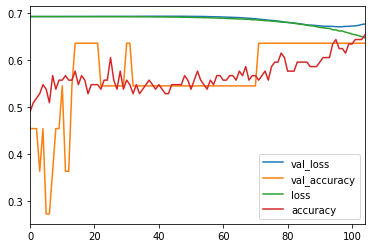

In [197]:
pd.DataFrame(model.history.history).plot()

In [198]:
#在训练集上的拟合结果
y_train_predict=model.predict(X_train)
y_train_predict=y_train_predict[:,0]
y_train_predict>0.5
y_train_predict=[int(i) for i in y_train_predict>0.5]
y_train_predict=np.array(y_train_predict)
from sklearn import metrics
print("精确度等指标：")
print(metrics.classification_report(y_train,y_train_predict))
print("混淆矩阵：")
print(metrics.confusion_matrix(y_train,y_train_predict))

精确度等指标：
              precision    recall  f1-score   support

         0.0       0.71      0.52      0.60        52
         1.0       0.62      0.79      0.69        52

    accuracy                           0.65       104
   macro avg       0.67      0.65      0.65       104
weighted avg       0.67      0.65      0.65       104

混淆矩阵：
[[27 25]
 [11 41]]


In [199]:
#在测试集上的拟合结果
y_test_predict=model.predict(X_test)
y_test_predict=y_test_predict[:,0]
y_test_predict>0.5
y_test_predict=[int(i) for i in y_test_predict>0.5]
y_test_predict=np.array(y_test_predict)
from sklearn import metrics
print("精确度等指标：")
print(metrics.classification_report(y_test,y_test_predict))
print("混淆矩阵：")
print(metrics.confusion_matrix(y_test,y_test_predict))

精确度等指标：
              precision    recall  f1-score   support

         0.0       0.57      0.80      0.67         5
         1.0       0.75      0.50      0.60         6

    accuracy                           0.64        11
   macro avg       0.66      0.65      0.63        11
weighted avg       0.67      0.64      0.63        11

混淆矩阵：
[[4 1]
 [3 3]]
